In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from tqdm import tqdm

# Image Panorama Stitching

In [2]:
img1 = cv2.imread('img1.jpg')
img2 = cv2.imread('img2.jpg')

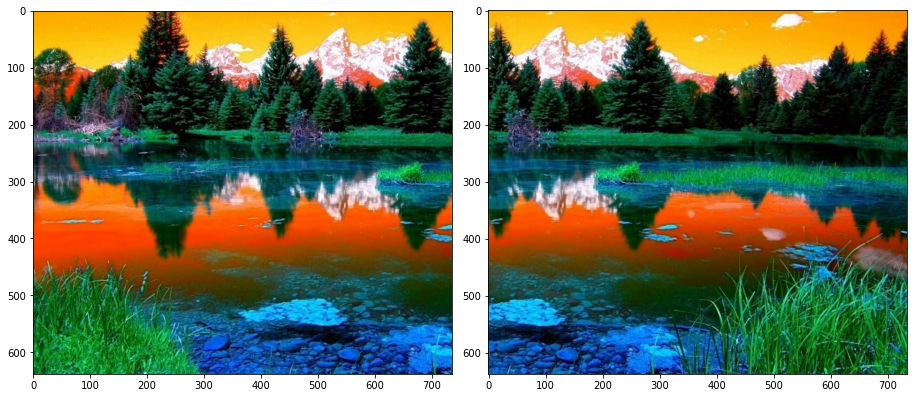

In [4]:
fig = plt.figure(figsize=(6.4 * 2, 4.8 * 2))

plt.subplot(121)
plt.imshow(img2,)

plt.subplot(122)
plt.imshow(img1,)

fig.tight_layout()
plt.show()

In [5]:
descriptor = cv2.xfeatures2d.SIFT_create()

[ WARN:0] global /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-r0utbq5z/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (15) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


In [6]:
kp1, desc1 = descriptor.detectAndCompute(img1, None)
kp2, desc2 = descriptor.detectAndCompute(img2, None)

![alt text](knn_example.png "Title")

In [7]:
FLANN_INDEX_KDTREE = 2
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
# flann = cv2.BFMatcher()

In [14]:
matches = flann.match(desc2, desc1)
print(matches[0].distance)

matches = flann.knnMatch(desc2, desc1, k=5)
print([m.distance for m in matches[0]])

319.2679138183594
[319.2679138183594, 337.78692626953125, 348.0, 349.3250732421875, 353.482666015625]


In [15]:
if (desc1 is not None and desc2 is not None and len(desc1) >=2 and len(desc2) >= 2):
    rawMatch = flann.knnMatch(desc2, desc1, k=2)
    matches = []
    # ensure the distance is within a certain ratio of each other (i.e. Lowe's ratio test)
    ratio = 0.75
    for m in rawMatch:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append(m[0])

In [16]:
list_kp1 = np.array([kp1[mat.trainIdx].pt for mat in matches])
list_kp2 = np.array([kp2[mat.queryIdx].pt for mat in matches])

In [19]:
if len(matches) > 4:
    (H, status) = cv2.findHomography(list_kp1, list_kp2, cv2.RANSAC)

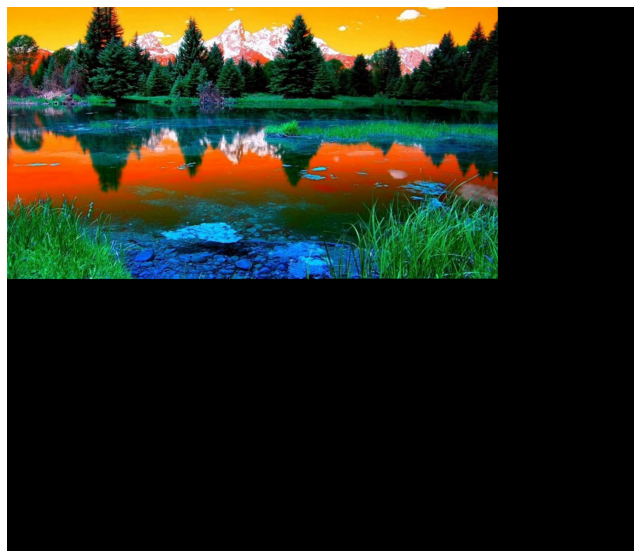

In [21]:
# Apply panorama correction
width = img1.shape[1] + img2.shape[1]
height = img2.shape[0] + img2.shape[0]

result = cv2.warpPerspective(img1, H, (width, height))

result[0:img2.shape[0], 0:img2.shape[1]] = img2

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

# Pazzle

## Step by step 

In [22]:
def get_images(path="puzzle/china_shuffle"):
    images_path = os.listdir(path)
    images = []
    for im in images_path:
        img = cv2.imread(os.path.join(path, im))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        images.append(img)

    return np.array(images)

In [23]:
path = 'puzzle/china'
images = get_images(path)[3:5]
print(images.shape)

(2, 256, 256)


In [24]:
img1, img2 = images[0], images[1]

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)

print(des1.shape, des2.shape)

(178, 128) (227, 128)


In [25]:
matches = bf.match(des2, des1)

for i in range(3):
    m = matches[i]
    line = 'match info: \n1) distance: {}\n2) imgIdx: {}\n3) queryIdx: {}\n4) trainIdx: {}'.format(m.distance, m.imgIdx, m.queryIdx, m.trainIdx)
    print(line)

match info: 
1) distance: 1393.0
2) imgIdx: 0
3) queryIdx: 0
4) trainIdx: 108
match info: 
1) distance: 1180.0
2) imgIdx: 0
3) queryIdx: 1
4) trainIdx: 109
match info: 
1) distance: 1108.0
2) imgIdx: 0
3) queryIdx: 2
4) trainIdx: 113


In [26]:
matches = sorted(matches, key=lambda x: x.distance)
good_matches = matches[:10]

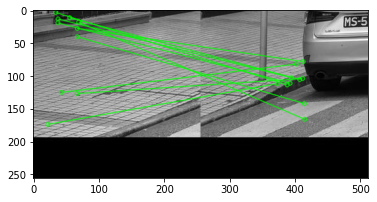

In [27]:
#-- Draw matches
img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1] + img2.shape[1], 3), dtype=np.uint8)

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                  )

cv2.drawMatches(img1, kp1, img2, kp2, good_matches, img_matches, **draw_params)

#-- Show detected matches
plt.imshow(img_matches)

In [28]:
list_kp1 = np.array([kp1[mat.trainIdx].pt for mat in good_matches])
list_kp2 = np.array([kp2[mat.queryIdx].pt for mat in good_matches])

print(list_kp1)

[[213.24766541 191.41036987]
 [219.53704834 159.92384338]
 [207.2285614  159.0423584 ]
 [222.95031738 133.35267639]
 [201.40098572 162.35340881]
 [205.81182861 131.3394165 ]
 [188.40406799 192.50871277]
 [222.16407776 128.587677  ]
 [223.92866516 142.9715271 ]
 [223.39649963 138.65258789]]


In [29]:
x, y = list_kp1[:, 0] - list_kp2[:, 0], list_kp1[:, 1] - list_kp2[:, 1]
angles = [math.degrees(math.atan2(y[elem], x[elem])) for elem in range(len(x))]

np.std(angles)

0.012300213028710887

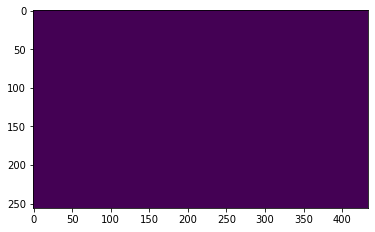

In [30]:
diff_x, diff_y = int(np.mean(x)), int(np.mean(y))

img3 = np.zeros((max(img1.shape[0], abs(diff_y) + img2.shape[0], img1.shape[0] - diff_y),
                 max((img1.shape[1], abs(diff_x) + img2.shape[1], img1.shape[1] - diff_x))))

plt.imshow(img3)

In [31]:
diff_x1, diff_y1 = max(0, -diff_x), max(0, -diff_y)
diff_x2, diff_y2 = max(0, diff_x), max(0, diff_y)

print(diff_x1, diff_y1)
print(diff_x2, diff_y2)

img3[diff_y1:diff_y1 + img1.shape[0], diff_x1:diff_x1 + img1.shape[1]] = img1
img3[diff_y2:diff_y2 + img2.shape[0], diff_x2:diff_x2 + img2.shape[1]] = img2

0 0
178 0


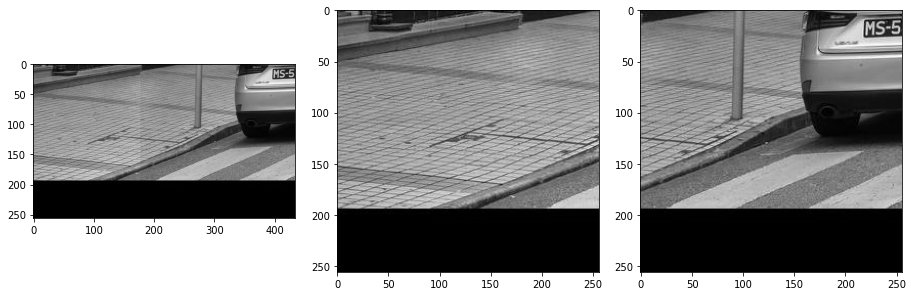

In [32]:
fig = plt.figure(figsize=(6.4 * 2, 4.8 * 2))

plt.subplot(131)
plt.imshow(img3, cmap='gray')

plt.subplot(132)
plt.imshow(img1, cmap='gray')

plt.subplot(133)
plt.imshow(img2, cmap='gray')

fig.tight_layout()
plt.show()

## All solution

In [33]:
def stitcher(img1, img2, match_number=20, best_match_number=5, angle_eps=2):
    img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=False)

    if des2 is not None and des1 is not None:
        matches = bf.match(des2, des1)
        matches = sorted(matches, key=lambda x: x.distance)
        if len(matches) > match_number:
            matches = matches[:best_match_number]
            list_kp1 = np.array([kp1[mat.trainIdx].pt for mat in matches])
            list_kp2 = np.array([kp2[mat.queryIdx].pt for mat in matches])
            x, y = list_kp1[:, 0] - list_kp2[:, 0], list_kp1[:, 1] - list_kp2[:, 1]
            angles = [math.degrees(math.atan2(y[elem], x[elem])) for elem in range(len(x))]

            if np.std(angles) < angle_eps:
                diff_x, diff_y = int(np.mean(x)), int(np.mean(y))
                img3 = np.zeros((max(img1.shape[0], abs(diff_y) + img2.shape[0], img1.shape[0] - diff_y),
                                 max((img1.shape[1], abs(diff_x) + img2.shape[1], img1.shape[1] - diff_x))))
                diff_x1, diff_y1 = max(0, -diff_x), max(0, -diff_y)
                diff_x2, diff_y2 = max(0, diff_x), max(0, diff_y)

                img3[diff_y1:diff_y1 + img1.shape[0], diff_x1:diff_x1 + img1.shape[1]] = img1
                img3[diff_y2:diff_y2 + img2.shape[0], diff_x2:diff_x2 + img2.shape[1]] = img2
                return img3

In [46]:
path = 'puzzle/china_shuffle//'
images = get_images(path)
random_idxs = np.arange(0, len(images))
np.random.shuffle(random_idxs)
images = images[random_idxs]

In [47]:
res = images[0]
images = np.delete(images, 0, 0)
count = 0

pbar = tqdm(total=150)
while len(images) >= 1 and count <= 150:
    idx = count % len(images)
    count += 1
    cur = stitcher(res, images[idx])  # match_number=20 // (k + 1), best_match_number=5 + 3 * k, angle_eps=2 + 5 * k)
    if cur is not None:
        res = cur
        images = np.delete(images, idx, 0)
        
    pbar.update()





  0%|                                                                       | 0/150 [00:00<?, ?it/s]



  2%|█▎                                                             | 3/150 [00:00<00:06, 23.80it/s]



  4%|██▌                                                            | 6/150 [00:00<00:06, 22.04it/s]



  6%|███▊                                                           | 9/150 [00:00<00:06, 21.45it/s]



  8%|████▉                                                         | 12/150 [00:00<00:07, 18.86it/s]



  9%|█████▊                                                        | 14/150 [00:00<00:08, 15.76it/s]



 11%|██████▌                                                       | 16/150 [00:00<00:09, 13.96it/s]



 12%|███████▍                                                      | 18/150 [00:01<00:10, 12.62it/s]



 13%|████████▎                                                     | 20/150 [00:01<00:12, 10.61it/s]



 15%|█████████                                              

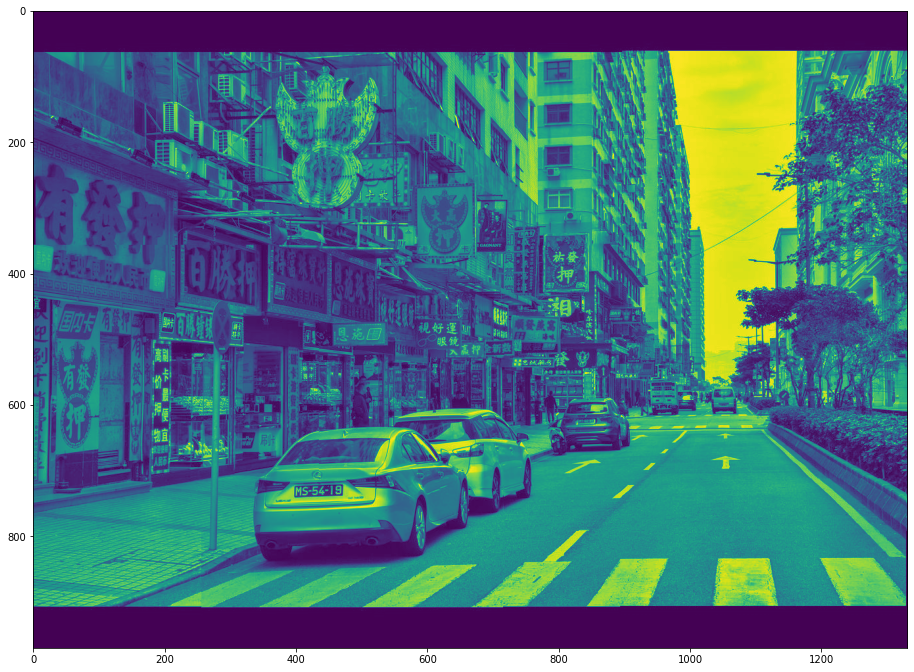

In [48]:
fig = plt.figure(figsize=(6.4 * 2, 4.8 * 2))

plt.imshow(res)

fig.tight_layout()
plt.show()